In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

RAW   = "../data/raw/"
OUT   = "../data/processed/"

## Load & Clean BPS Health Data

In [2]:
bps_years = [2020, 2021, 2022, 2023, 2024]
bps_frames = []

for year in bps_years:
    df = pd.read_excel(
        f"{RAW}bps_health_{year}.xlsx",
        sheet_name="Sheet1",
        header=None
    )
    df = df.iloc[3:].copy()
    df.columns = ["province", "health_complaint_pct"]
    df = df[df["province"] != "INDONESIA"].copy()
    df["health_complaint_pct"] = pd.to_numeric(
        df["health_complaint_pct"], errors="coerce"
    )
    df["year"] = year
    df = df.reset_index(drop=True)
    bps_frames.append(df)
bps = pd.concat(bps_frames, ignore_index=True)

In [3]:
print(f"BPS combined shape: {bps.shape}")
print(f"Years     : {sorted(bps['year'].unique())}")
print(f"Provinces : {bps['province'].nunique()}")
print(f"Missing   : {bps['health_complaint_pct'].isnull().sum()} rows")

BPS combined shape: (190, 3)
Years     : [2020, 2021, 2022, 2023, 2024]
Provinces : 38
Missing   : 16 rows


In [4]:
# Handle Missing Values (Papua provinces pre-2024)
# Strategy: forward-fill within each province (chronological order)
# Rationale: Papua provinces were newly defined; use nearest known value

bps = bps.sort_values(["province", "year"]).reset_index(drop=True)

missing_before = bps["health_complaint_pct"].isnull().sum()
bps["health_complaint_pct"] = bps.groupby("province")["health_complaint_pct"] \
    .transform(lambda x: x.fillna(x.median()))

missing_after = bps["health_complaint_pct"].isnull().sum()
print(f"Missing value imputation:")
print(f"Before : {missing_before}")
print(f"After  : {missing_after}")

Missing value imputation:
Before : 16
After  : 0


In [5]:
# Standardize Province Names
# Trim whitespace, title case for consistency
bps["province"] = bps["province"].str.strip().str.upper()

In [6]:
# Add Region Grouping to BPS
# Map each province to PL-region (for joining with FMCG data)
province_to_region = {
    # PL-West → Sumatera + Kalimantan Barat
    "ACEH"                  : "PL-West",
    "SUMATERA UTARA"        : "PL-West",
    "SUMATERA BARAT"        : "PL-West",
    "RIAU"                  : "PL-West",
    "JAMBI"                 : "PL-West",
    "SUMATERA SELATAN"      : "PL-West",
    "BENGKULU"              : "PL-West",
    "LAMPUNG"               : "PL-West",
    "KEP. BANGKA BELITUNG"  : "PL-West",
    "KEP. RIAU"             : "PL-West",
    "KALIMANTAN BARAT"      : "PL-West",

    # PL-Central → Jawa + Bali + NTB/NTT
    "DKI JAKARTA"           : "PL-Central",
    "JAWA BARAT"            : "PL-Central",
    "JAWA TENGAH"           : "PL-Central",
    "DI YOGYAKARTA"         : "PL-Central",
    "JAWA TIMUR"            : "PL-Central",
    "BANTEN"                : "PL-Central",
    "BALI"                  : "PL-Central",
    "NUSA TENGGARA BARAT"   : "PL-Central",
    "NUSA TENGGARA TIMUR"   : "PL-Central",

    # PL-North → Kalimantan (excl. Barat) + Sulawesi
    "KALIMANTAN TENGAH"     : "PL-North",
    "KALIMANTAN SELATAN"    : "PL-North",
    "KALIMANTAN TIMUR"      : "PL-North",
    "KALIMANTAN UTARA"      : "PL-North",
    "SULAWESI UTARA"        : "PL-North",
    "SULAWESI TENGAH"       : "PL-North",
    "SULAWESI SELATAN"      : "PL-North",
    "SULAWESI TENGGARA"     : "PL-North",
    "GORONTALO"             : "PL-North",
    "SULAWESI BARAT"        : "PL-North",

    # PL-South → Maluku + Papua
    "MALUKU"                : "PL-South",
    "MALUKU UTARA"          : "PL-South",
    "PAPUA BARAT"           : "PL-South",
    "PAPUA BARAT DAYA"      : "PL-South",
    "PAPUA"                 : "PL-South",
    "PAPUA SELATAN"         : "PL-South",
    "PAPUA TENGAH"          : "PL-South",
    "PAPUA PEGUNUNGAN"      : "PL-South",
}

bps["pl_region"] = bps["province"].map(province_to_region)

unmapped = bps[bps["pl_region"].isnull()]["province"].unique()
if len(unmapped) > 0:
    print(f"Unmapped provinces: {unmapped}")
else:
    print(f"All provinces mapped to PL-regions successfully")

print(f"\nRegion distribution:")
print(bps.groupby("pl_region")["province"].nunique().to_string())

All provinces mapped to PL-regions successfully

Region distribution:
pl_region
PL-Central     9
PL-North      10
PL-South       8
PL-West       11


In [7]:
bps.to_csv(f"{OUT}bps_health_clean.csv", index=False)

## Load & Clean FMCG Data

In [8]:
fmcg = pd.read_csv(f"{RAW}FMCG_2022_2024.csv")
print(f"Loaded shape: {fmcg.shape}")

Loaded shape: (190757, 14)


In [9]:
fmcg["date"] = pd.to_datetime(fmcg["date"])
fmcg["year"]  = fmcg["date"].dt.year
fmcg["month"] = fmcg["date"].dt.month
fmcg["year_month"] = fmcg["date"].dt.strftime("%Y-%m")
print(f"Date range: {fmcg['date'].min().date()} → {fmcg['date'].max().date()}")

Date range: 2022-01-21 → 2024-12-31


In [10]:
print(fmcg.isnull().sum().to_string())

date               0
sku                0
brand              0
segment            0
category           0
channel            0
region             0
pack_type          0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
delivered_qty      0
units_sold         0
year               0
month              0
year_month         0


In [11]:
for col in ["units_sold", "price_unit", "stock_available"]:
    Q1  = fmcg[col].quantile(0.25)
    Q3  = fmcg[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = fmcg[(fmcg[col] < lower) | (fmcg[col] > upper)]
    print(f"  {col:20s} | bounds: [{lower:.1f}, {upper:.1f}] | outliers: {len(outliers)}")

  units_sold           | bounds: [-7.5, 44.5] | outliers: 7709
  price_unit           | bounds: [-2.2, 12.8] | outliers: 0
  stock_available      | bounds: [22.0, 294.0] | outliers: 4914


Outlier Strategy

units_sold = 0 when stock_available = 0 is VALID (stockout)

Negative values = data entry error → remove

Extreme high values → cap at 99.9th percentile (winsorize)

In [12]:
# Remove data entry errors
before = len(fmcg)
fmcg = fmcg[fmcg["units_sold"] >= 0]
fmcg = fmcg[fmcg["price_unit"] > 0]
after = len(fmcg)
print(f"Removed {before - after} data entry error rows")

Removed 3 data entry error rows


In [13]:
# Winsorize units_sold at 99.9th percentile
cap_units = fmcg["units_sold"].quantile(0.999)
fmcg["units_sold"] = fmcg["units_sold"].clip(upper=cap_units)
print(f"Winsorized units_sold at 99.9th pct: {cap_units:.0f}")

Winsorized units_sold at 99.9th pct: 91


In [15]:
# Derive Revenue & Margin
# Assumption: gross margin ~30% for FMCG category (industry benchmark)
GROSS_MARGIN_RATE = 0.30

fmcg["revenue"]      = fmcg["units_sold"] * fmcg["price_unit"]
fmcg["gross_margin"] = fmcg["revenue"] * GROSS_MARGIN_RATE

# Stock Rate (availability indicator)
# stock_rate = stock_available / (stock_available + units_sold)
# Closer to 0 = stockout risk; closer to 1 = well-stocked
fmcg["stock_rate"] = fmcg["stock_available"] / \
    (fmcg["stock_available"] + fmcg["units_sold"] + 1)

In [16]:
fmcg["region"] = fmcg["region"].str.strip()
print(f"Regions in FMCG: {sorted(fmcg['region'].unique())}")

Regions in FMCG: ['PL-Central', 'PL-North', 'PL-South']


In [17]:
fmcg.to_csv(f"{OUT}fmcg_clean.csv", index=False)

## Load Seasonal Calendar

In [18]:
seasonal = pd.read_csv(f"{RAW}seasonal_calendar.csv")
print(f"Loaded shape: {seasonal.shape}")
print(f"Columns: {seasonal.columns.tolist()}")

Loaded shape: (60, 10)
Columns: ['year_month', 'year', 'month', 'month_name', 'is_rainy_season', 'is_ramadan', 'is_lebaran', 'is_school_holiday', 'is_dengue_peak', 'demand_pressure_index']


In [19]:
# Aggregate FMCG to monthly × region level
fmcg_monthly = fmcg.groupby(["year", "month", "year_month", "region"]).agg(
    total_units_sold    = ("units_sold",      "sum"),
    total_revenue       = ("revenue",         "sum"),
    total_gross_margin  = ("gross_margin",    "sum"),
    avg_stock_available = ("stock_available", "mean"),
    avg_stock_rate      = ("stock_rate",      "mean"),
    avg_price_unit      = ("price_unit",      "mean"),
    total_promotions    = ("promotion_flag",  "sum"),
    transaction_count   = ("units_sold",      "count"),
).reset_index()
print(f"FMCG monthly aggregated: {fmcg_monthly.shape}")

FMCG monthly aggregated: (108, 12)


In [20]:
# Aggregate BPS to region × year level
bps_region = bps.groupby(["year", "pl_region"]).agg(
    avg_health_complaint_pct = ("health_complaint_pct", "mean"),
    max_health_complaint_pct = ("health_complaint_pct", "max"),
    province_count           = ("province",             "count"),
).reset_index()
bps_region.rename(columns={"pl_region": "region"}, inplace=True)
print(f"BPS region aggregated: {bps_region.shape}")

BPS region aggregated: (20, 5)


In [21]:
# Normalize health_complaint_pct to 0–100 scale (Min-Max)
min_val = bps_region["avg_health_complaint_pct"].min()
max_val = bps_region["avg_health_complaint_pct"].max()

bps_region["health_risk_score"] = (
    (bps_region["avg_health_complaint_pct"] - min_val) /
    (max_val - min_val) * 100
).round(2)

print(f"Health Risk Score engineered")
print(f"Min HRS: {bps_region['health_risk_score'].min():.1f}")
print(f"Max HRS: {bps_region['health_risk_score'].max():.1f}")
print(f"Mean HRS by region:")
print(bps_region.groupby("region")["health_risk_score"].mean().round(2).to_string())

Health Risk Score engineered
Min HRS: 0.0
Max HRS: 100.0
Mean HRS by region:
region
PL-Central    78.76
PL-North      60.07
PL-South       5.07
PL-West       61.06


In [23]:
# Join FMCG + BPS (on year + region) 
master = fmcg_monthly.merge(
    bps_region[["year", "region", "avg_health_complaint_pct",
                "max_health_complaint_pct", "health_risk_score"]],
    on=["year", "region"],
    how="left"
)
print(f"After FMCG + BPS join: {master.shape}")

# Join + Seasonal Calendar
master = master.merge(
    seasonal[["year", "month", "is_rainy_season", "is_ramadan",
              "is_lebaran", "is_school_holiday", "is_dengue_peak",
              "demand_pressure_index"]],
    on=["year", "month"],
    how="left"
)
print(f"After + Seasonal join : {master.shape}")

After FMCG + BPS join: (108, 15)
After + Seasonal join : (108, 21)


In [25]:
# Final Missing Check
print(master.isnull().sum()[master.isnull().sum() > 0].to_string())
# Fill any remaining NaN in HRS with regional median
master["health_risk_score"] = master.groupby("region")["health_risk_score"] \
    .transform(lambda x: x.fillna(x.median()))

Series([], )


In [27]:
# Risk Category Label
def risk_category(score):
    if score >= 66:   return "HIGH"
    elif score >= 33: return "MEDIUM"
    else:             return "LOW"
master["risk_category"] = master["health_risk_score"].apply(risk_category)

# Stock Category Label
stock_33 = master["avg_stock_rate"].quantile(0.33)
stock_66 = master["avg_stock_rate"].quantile(0.66)

def stock_category(rate):
    if rate >= stock_66:  return "HIGH"
    elif rate >= stock_33: return "MEDIUM"
    else:                  return "LOW"
master["stock_category"] = master["avg_stock_rate"].apply(stock_category)

# Strategic Quadrant (core insight column)
def quadrant(row):
    r = row["risk_category"]
    s = row["stock_category"]
    if r == "HIGH"   and s == "LOW":    return "🔴 Critical Gap"
    elif r == "HIGH" and s == "HIGH":   return "🟡 Well-Served"
    elif r == "LOW"  and s == "LOW":    return "🟠 Underserved"
    else:                               return "🟢 Surplus"
master["strategic_quadrant"] = master.apply(quadrant, axis=1)
print(f"Strategic Quadrant distribution:")
print(master["strategic_quadrant"].value_counts().to_string())

Strategic Quadrant distribution:
strategic_quadrant
🟢 Surplus         61
🟡 Well-Served     17
🔴 Critical Gap    16
🟠 Underserved     14


In [29]:
master.to_csv(f"{OUT}master_integrated.csv", index=False)
bps_region.to_csv(f"{OUT}bps_region_hrs.csv", index=False)

print("Master columns:")
for col in master.columns:
    print(f"    - {col}")

Master columns:
    - year
    - month
    - year_month
    - region
    - total_units_sold
    - total_revenue
    - total_gross_margin
    - avg_stock_available
    - avg_stock_rate
    - avg_price_unit
    - total_promotions
    - transaction_count
    - avg_health_complaint_pct
    - max_health_complaint_pct
    - health_risk_score
    - is_rainy_season
    - is_ramadan
    - is_lebaran
    - is_school_holiday
    - is_dengue_peak
    - demand_pressure_index
    - risk_category
    - stock_category
    - strategic_quadrant


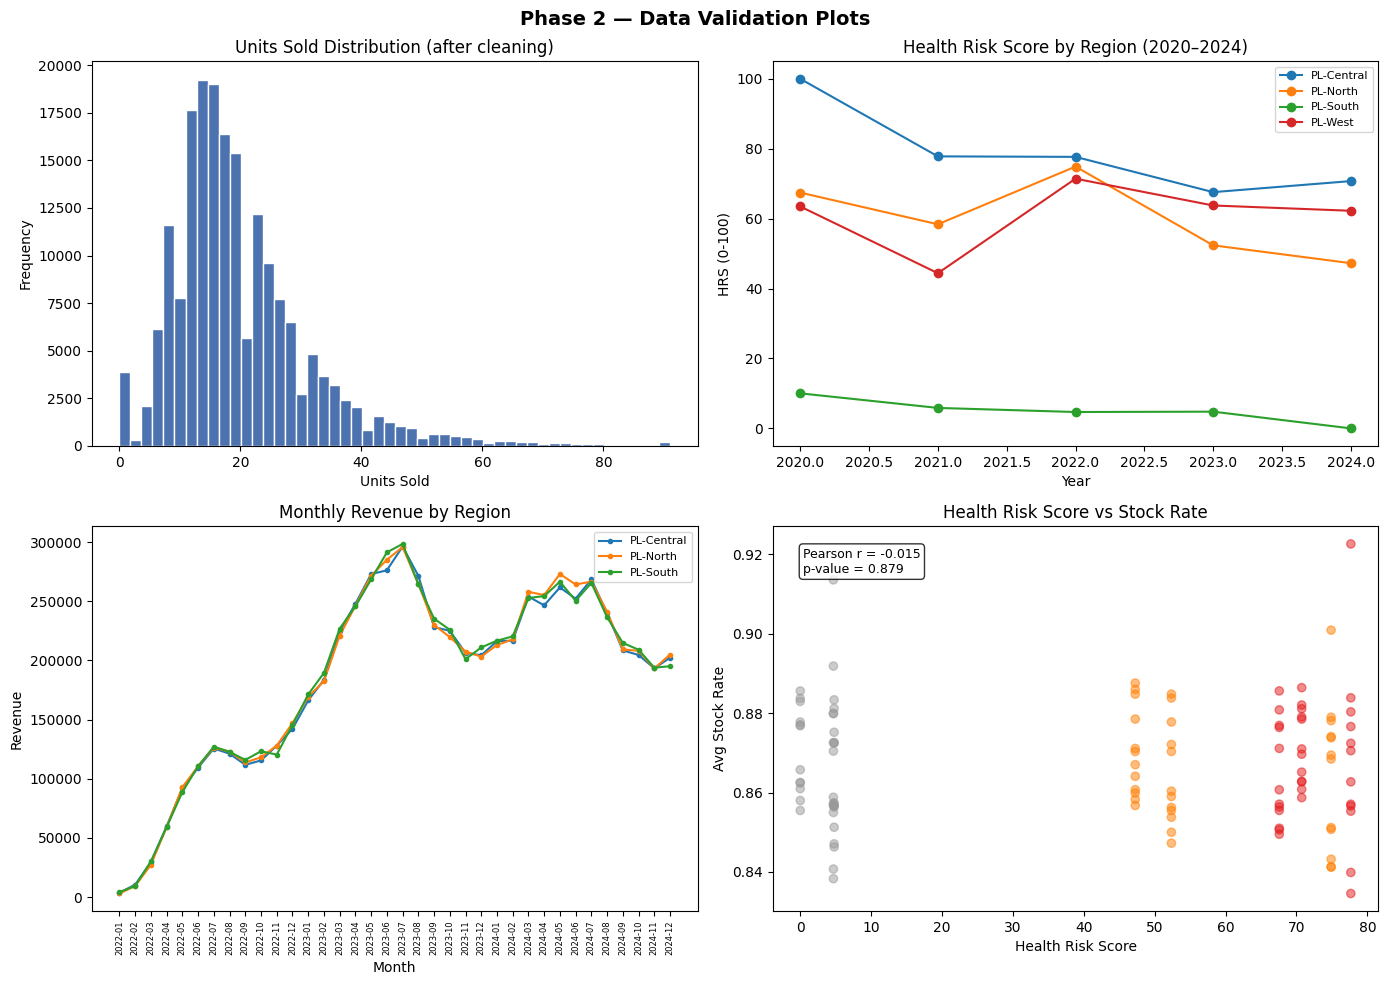

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Phase 2 — Data Validation Plots", fontsize=14, fontweight="bold")

# Plot 1: Units Sold Distribution
axes[0, 0].hist(fmcg["units_sold"], bins=50, color="#4C72B0", edgecolor="white")
axes[0, 0].set_title("Units Sold Distribution (after cleaning)")
axes[0, 0].set_xlabel("Units Sold")
axes[0, 0].set_ylabel("Frequency")

# Plot 2: Health Risk Score by Region & Year
pivot = bps_region.pivot(index="year", columns="region", values="health_risk_score")
pivot.plot(ax=axes[0, 1], marker="o")
axes[0, 1].set_title("Health Risk Score by Region (2020–2024)")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("HRS (0-100)")
axes[0, 1].legend(fontsize=8)

# Plot 3: Monthly Revenue by Region
monthly_rev = master.groupby(["year_month", "region"])["total_revenue"].sum().reset_index()
for region in master["region"].unique():
    subset = monthly_rev[monthly_rev["region"] == region]
    axes[1, 0].plot(subset["year_month"], subset["total_revenue"], label=region, marker=".")
axes[1, 0].set_title("Monthly Revenue by Region")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Revenue")
axes[1, 0].tick_params(axis="x", rotation=90, labelsize=6)
axes[1, 0].legend(fontsize=8)

# Plot 4: HRS vs Avg Stock Rate scatter
axes[1, 1].scatter(
    master["health_risk_score"],
    master["avg_stock_rate"],
    c=master["region"].astype("category").cat.codes,
    alpha=0.5, cmap="Set1"
)
axes[1, 1].set_title("Health Risk Score vs Stock Rate")
axes[1, 1].set_xlabel("Health Risk Score")
axes[1, 1].set_ylabel("Avg Stock Rate")

# Correlation annotation
corr, pval = stats.pearsonr(
    master["health_risk_score"].dropna(),
    master["avg_stock_rate"][master["health_risk_score"].notna()]
)
axes[1, 1].annotate(
    f"Pearson r = {corr:.3f}\np-value = {pval:.3f}",
    xy=(0.05, 0.88), xycoords="axes fraction",
    fontsize=9, bbox=dict(boxstyle="round", fc="white", alpha=0.8)
)

plt.tight_layout()
plt.savefig(f"{OUT}phase2_validation_plots.png", dpi=150, bbox_inches="tight")
plt.show()

In [31]:
print(f"Master dataset : {master.shape[0]} rows × {master.shape[1]} columns")
print(f"Date range     : {master['year_month'].min()} → {master['year_month'].max()}")
print(f"Regions        : {sorted(master['region'].unique())}")

Master dataset : 108 rows × 24 columns
Date range     : 2022-01 → 2024-12
Regions        : ['PL-Central', 'PL-North', 'PL-South']
